# Draw Causal Graph

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.
And to draw the causal graph, we need to import `make_dot` method from `lingam.utils`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, make_dot_highlight

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.23.4', '1.5.0', '0.19.1', '1.7.1']


## Draw the result of LiNGAM
First, we can draw a simple graph that is the result of LiNGAM.

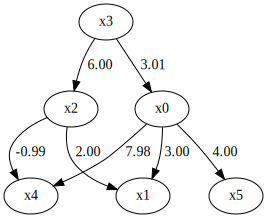

In [2]:
x3 = np.random.uniform(size=10000)
x0 = 3.0*x3 + np.random.uniform(size=10000)
x2 = 6.0*x3 + np.random.uniform(size=10000)
x1 = 3.0*x0 + 2.0*x2 + np.random.uniform(size=10000)
x5 = 4.0*x0 + np.random.uniform(size=10000)
x4 = 8.0*x0 - 1.0*x2 + np.random.uniform(size=10000)
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

model = lingam.DirectLiNGAM()
model.fit(X)
make_dot(model.adjacency_matrix_)

If we want to change the variable name, we can use `labels`.

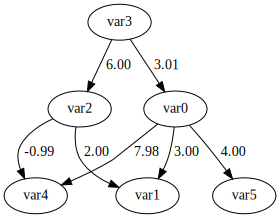

In [3]:
labels = [f'var{i}' for i in range(X.shape[1])]
make_dot(model.adjacency_matrix_, labels=labels)

## Save graph
The created dot data can be saved as an image file in addition to being displayed in Jupyter Notebook.

In [4]:
dot = make_dot(model.adjacency_matrix_, labels=labels)

# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')

'dag.png'

## Draw the result of LiNGAM with prediction model
For example, we create a linear regression model with x0 as the target variable.

In [5]:
from sklearn.linear_model import LinearRegression

target = 0
features = [i for i in range(X.shape[1]) if i != target]
reg = LinearRegression()

reg.fit(X.iloc[:, features], X.iloc[:, target])

LinearRegression()

By specify `prediction_feature_indices` and `prediction_coefs` that can be obtained from the prediction model, we can draw the prediction model with the causal structure.

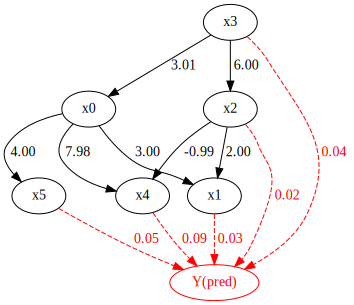

In [6]:
make_dot(model.adjacency_matrix_, prediction_feature_indices=features, prediction_coefs=reg.coef_)

Also, we can change the label of the target variable by `prediction_target_label`, omit the coefficient of prediction model without `prediction_coefs`, and change the color by `prediction_line_color`.

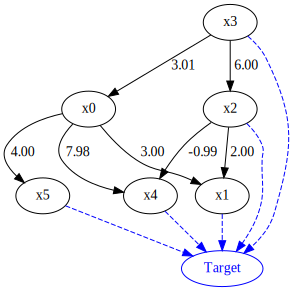

In [7]:
make_dot(model.adjacency_matrix_, prediction_feature_indices=features, prediction_target_label='Target', prediction_line_color='#0000FF')

In addition to the above, we can use `prediction_feature_importance` to draw the importance of the prediction model as an edge label.

In [8]:
import lightgbm as lgb

target = 0
features = [i for i in range(X.shape[1]) if i != target]
reg = lgb.LGBMRegressor(random_state=0)
reg.fit(X.iloc[:, features], X.iloc[:, target])
reg.feature_importances_

array([619, 205, 310, 957, 909], dtype=int32)

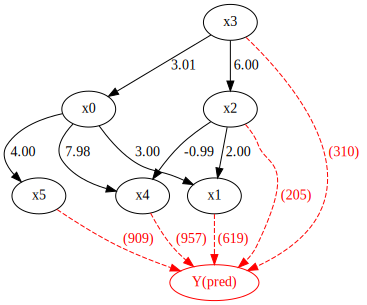

In [9]:
make_dot(model.adjacency_matrix_, prediction_feature_indices=features, prediction_feature_importance=reg.feature_importances_)

# Highlight paths between specified nodes

`make_dot` highlights the path specified by the path argument.

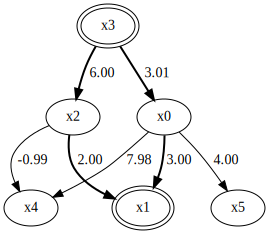

In [10]:
make_dot(model.adjacency_matrix_, path=(3, 1))

If detect_cycles is True, simple cycles are displayed with a dashed edge.

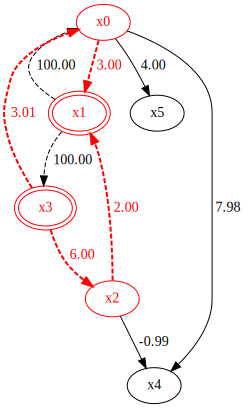

In [11]:
# add edges to make simple cycles
result = model.adjacency_matrix_.copy()
result[0, 1] = 100
result[3, 1] = 100

make_dot(result, path=(3, 1), path_color="red", detect_cycle=True)

## Draw the result of LiNGAM with emphasis on descendants and ancestors

`make_dot_highlight` highlights descendants or ancestors of the graph.

The first argument is the result and the second argument is the index of the target variable. There are four types of cluster names: target, ancestor, descendant, and others. `target` contains only the node specified in the second argument. Nodes that are ancestors or descendants of target belong to `ancestor` or `descendant`. The number appended to the cluster name is the distance from `target`. Other nodes belong to `others`.

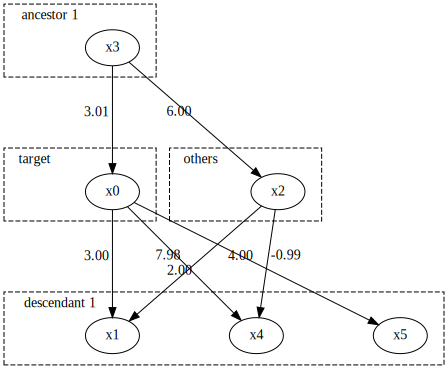

In [12]:
make_dot_highlight(model.adjacency_matrix_, 0)

It is also possible to disable the display of clusters of ancestors and descendants.

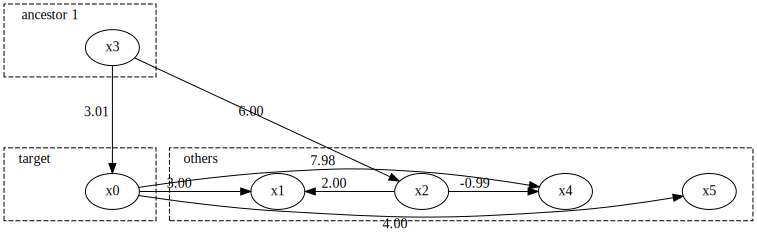

In [13]:
make_dot_highlight(model.adjacency_matrix_, 0, max_dsc=0, max_anc=None)

It is also possible to suppress the display of the `others` cluster.

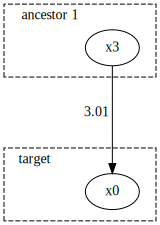

In [14]:
make_dot_highlight(model.adjacency_matrix_, 0, max_dsc=0, max_anc=None, draw_others=False)

## Draw the result of Bootstrap with emphasis on descendants and ancestors

It is possible to visualize results that include the cyclic portion, such as the result of a bootstrap.

In [15]:
result = model.bootstrap(X, n_sampling=100)

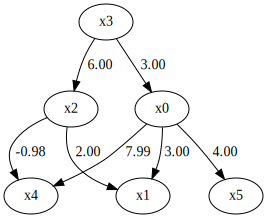

In [16]:
median = np.median(result.adjacency_matrices_, axis=0)
make_dot(median, lower_limit=0)

Applying `make_dot_highlight` to this graph draws the following graph. Dashed edges indicate simple cycles.

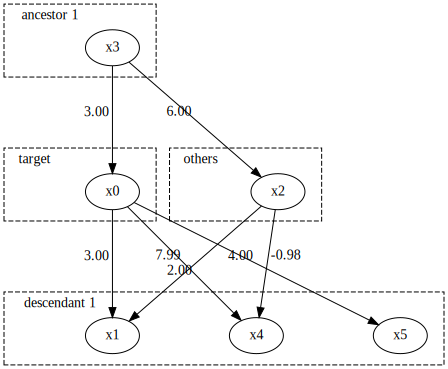

In [17]:
make_dot_highlight(median, 0, detect_cycle=True)

You can reduce the edges by setting lower_limit.

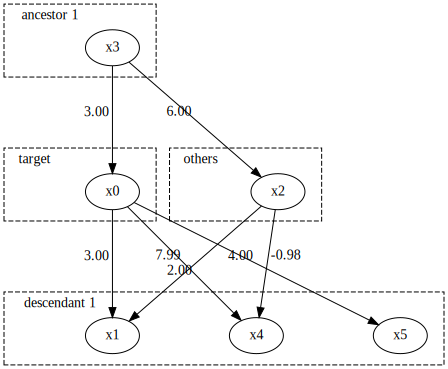

In [18]:
make_dot_highlight(median, 0, detect_cycle=True, lower_limit=0.1)

You can also set the color map and the spacing of the nodes.

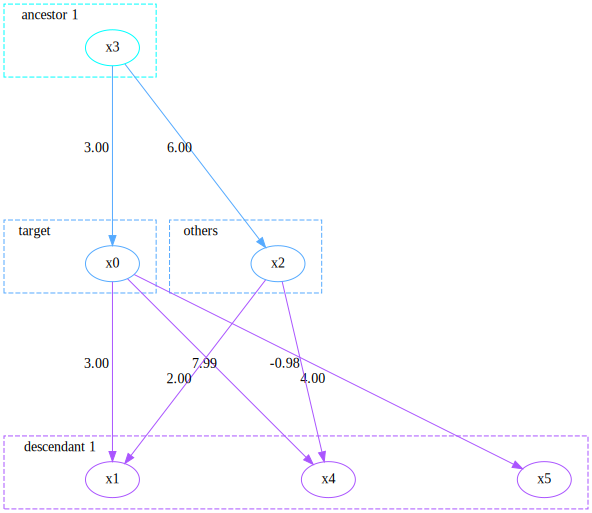

In [19]:
make_dot_highlight(median, 0, lower_limit=0.001, cmap="cool", vmargin=3, hmargin=3)